# Introduction
Author: Cory Mosiman  
Date: March 2nd, 2018


The purpose of this file is to provide a quick tutorial on:
- How do I read data in from a csv file?
- How do I manipulate dates/times in a pandas dataframe?
- How do I  manipulate rows, columns, etc. in a dataframe?

In [ ]:
import pandas as pd
import numpy as np
import os

In [17]:
# list the files in the data directory
data_dir = './../data/raw-data'
files = os.listdir(data_dir)
test_file = files[0]

In [22]:
# read the file in, skipping initial rows, passing in the date/time column as an index and parsing dates.
data = pd.read_csv(os.path.join(data_dir + os.sep + test_file), skiprows=6, index_col = [0], parse_dates=True)

# shows the index is correctly converted to a DatetimeIndex, super helpful for manipulations
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10080 entries, 2017-04-10 00:00:00 to 2017-04-16 23:59:00
Data columns (total 24 columns):
CH1-Bldg F1                    10080 non-null int64
CH3-Solar Input (F1)           10080 non-null int64
CH4-No CT                      10080 non-null int64
CH5-WSHP                       10080 non-null int64
CH6-Range                      10080 non-null int64
CH8-Microwave                  10080 non-null int64
CH9-Dishwasher                 10080 non-null int64
CH10-Mixer                     10080 non-null int64
CH11-Fridge in Back            10080 non-null int64
CH12-Front Display Case        10080 non-null int64
CH13-Back Middle Freezer       10080 non-null int64
CH14-Back Freezer near Wall    10080 non-null int64
CH15-Lighting{1}               10080 non-null int64
CH16-Gas Water Heater          10080 non-null int64
CH17-Gas Convection Oven       10080 non-null int64
CH18-Receptacle 1              10080 non-null int64
CH19-Receptacle 2       

In [23]:
# Now, we want to use the column names as part of the index.  
data_new = pd.DataFrame(data.stack(), columns = ['power_watts'])
data_new.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 232008 entries, (2017-04-10 00:00:00, CH1-Bldg F1) to (2017-04-16 23:59:00, 4065/Voltage)
Data columns (total 1 columns):
power_watts    232008 non-null float64
dtypes: float64(1)
memory usage: 2.5+ MB


In [24]:
# Notice how this is now different
print(type(data_new))
data_new.head()

<class 'pandas.core.frame.DataFrame'>


power_watts
 Date/Time                                  
2017-04-10 CH1-Bldg F1                2841.0
           CH3-Solar Input (F1)          0.0
           CH4-No CT                     0.0
           CH5-WSHP                      0.0
           CH6-Range                     0.0

In [25]:
# Let's give the index the correct names
data_new.index.names = ['date_time','channel']

In [26]:
# BAM
data_new.head()

power_watts
date_time  channel                          
2017-04-10 CH1-Bldg F1                2841.0
           CH3-Solar Input (F1)          0.0
           CH4-No CT                     0.0
           CH5-WSHP                      0.0
           CH6-Range                     0.0

In [27]:
# First off, let's make this simple and just look at full building energy consumption
# pd.IndexSlice is an object that basically simplifies selecting subsets from a multi-index
idx = pd.IndexSlice
channel_name = 'CH1-Bldg F1'
data_full_bldg = data_new.loc[idx[:,[channel_name]], :]
data_full_bldg.head()

,,power_watts
date_time,channel,
2017-04-10 00:00:00,CH1-Bldg F1,2841.0
2017-04-10 00:01:00,CH1-Bldg F1,2119.0
2017-04-10 00:02:00,CH1-Bldg F1,2014.0
2017-04-10 00:03:00,CH1-Bldg F1,2799.0
2017-04-10 00:04:00,CH1-Bldg F1,3644.0


In [28]:
# only use the date_time as the index value now
data_full_bldg.reset_index(level = 'channel', inplace=True)
data_full_bldg.head()

,channel,power_watts
date_time,,
2017-04-10 00:00:00,CH1-Bldg F1,2841.0
2017-04-10 00:01:00,CH1-Bldg F1,2119.0
2017-04-10 00:02:00,CH1-Bldg F1,2014.0
2017-04-10 00:03:00,CH1-Bldg F1,2799.0
2017-04-10 00:04:00,CH1-Bldg F1,3644.0


In [29]:
# Now I want to create some categorical features.  I extract the datetime from the index and pull
# out the day of the week and the hour
dates = pd.to_datetime(data_full_bldg.index)
type(dates)
day_of_week, hour = dates.weekday + 1, dates.hour

In [30]:
# We will create a new variable to encode the weekdays vs. weekends and add them to our dataframe
is_weekday = [True if day < 6 else False for day in day_of_week]
new_features = pd.DataFrame({'is_weekday': is_weekday, 'day_of_week':day_of_week, 'hour':hour}, index=dates)
new_features.head()

,day_of_week,hour,is_weekday
date_time,,,
2017-04-10 00:00:00,1,0,True
2017-04-10 00:01:00,1,0,True
2017-04-10 00:02:00,1,0,True
2017-04-10 00:03:00,1,0,True
2017-04-10 00:04:00,1,0,True


In [31]:
# Now we will encode the above variables as categorical, defaulting to a nominal (or unordered) 
# categorical variable
new_features['day_of_week'] = new_features['day_of_week'].astype('category')
new_features['hour'] = new_features['hour'].astype('category')
new_features['is_weekday'] = new_features['is_weekday'].astype('category')
new_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10080 entries, 2017-04-10 00:00:00 to 2017-04-16 23:59:00
Data columns (total 3 columns):
day_of_week    10080 non-null category
hour           10080 non-null category
is_weekday     10080 non-null category
dtypes: category(3)
memory usage: 109.6 KB


In [32]:
data_full_bldg_new_feats = pd.concat([data_full_bldg, new_features], axis = 1)

In [33]:
data_full_bldg_new_feats.head()

,channel,power_watts,day_of_week,hour,is_weekday
date_time,,,,,
2017-04-10 00:00:00,CH1-Bldg F1,2841.0,1,0,True
2017-04-10 00:01:00,CH1-Bldg F1,2119.0,1,0,True
2017-04-10 00:02:00,CH1-Bldg F1,2014.0,1,0,True
2017-04-10 00:03:00,CH1-Bldg F1,2799.0,1,0,True
2017-04-10 00:04:00,CH1-Bldg F1,3644.0,1,0,True


In [34]:
data_full_bldg_new_feats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10080 entries, 2017-04-10 00:00:00 to 2017-04-16 23:59:00
Data columns (total 5 columns):
channel        10080 non-null object
power_watts    10080 non-null float64
day_of_week    10080 non-null category
hour           10080 non-null category
is_weekday     10080 non-null category
dtypes: category(3), float64(1), object(1)
memory usage: 267.1+ KB


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
# NOT COMPLETE

In [214]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
X = data_full_bldg_new_feats.iloc[:,2:4]
y = data_full_bldg_new_feats['power_watts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
linreg = LinearRegression()

In [215]:
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [217]:
y_predict = linreg.predict(X_test)

In [218]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_predict)

6745658.8974036137

In [224]:
print(len(X_test), type(X_test))
print(len(y_test), type(y_test))
print(len(y_predict), type(y_predict))

3327 <class 'pandas.core.frame.DataFrame'>
3327 <class 'pandas.core.series.Series'>
3327 <class 'numpy.ndarray'>


In [228]:
X_test.head()

,day_of_week,hour
date_time,,
2016-08-07 19:43:00,7,19
2016-08-01 00:33:00,1,0
2016-08-01 22:49:00,1,22
2016-08-03 12:20:00,3,12
2016-08-03 06:32:00,3,6


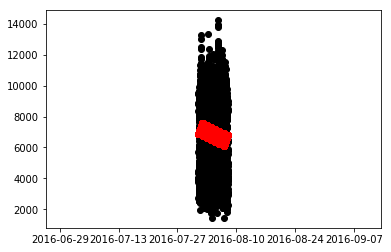

In [235]:
# import matplotlib.pyplot as plt
# %matplotlib inline

# plt.scatter(X_test.index, y_test, color = 'black')
# plt.scatter(X_test.index, y_predict, color = 'red')
# plt.show()